# Algoritmos de optimización - Trabajo Práctico<br>
Nombre y Apellidos: Maickol Hernandez Gonzalez  <br>
Url: https://github.com/.../03MAIR---Algoritmos-de-Optimizacion---/tree/master/TrabajoPractico<br>
Google Colab: https://colab.research.google.com/drive/xxxxxxxxxxxxxxxx <br>
                            

### Problema:

>2. Organizar los horarios de partidos de La Liga<br>

- Desde la La Liga de fútbol profesional se pretende organizar los horarios de los partidos de 
liga de cada jornada. Se conocen algunos datos que nos deben llevar a diseñar un 
algoritmo que realice la asignación de los partidos a los horarios de forma que maximice la 
audiencia. 
- Los horarios disponibles se conocen a priori y son los siguientes:
  
    | Día     | Horarios         |
    |---------|------------------|
    | Viernes | 20               |
    | Sábado  | 12, 16, 18, 20   |
    | Domingo | 12, 16, 18, 20   |
    | Lunes   | 20               |


- En primer lugar se clasifican los equipos en tres categorías según el numero de 
seguidores( que tiene relación directa con la audiencia). Hay 3 equipos en la 
categoría A, 11 equipos de categoría B y 6 equipos de categoría C.
- Se conoce estadísticamente la audiencia que genera cada partido según los equipos 
que se enfrentan y en horario de sábado a las 20h (el mejor en todos los casos)

    | Categoría   | Categoría A   | Categoría B    | Categoría C   |
    |-------------|---------------|----------------|---------------|
    | Categoría A | 2 Millones    | 1,3 Millones   | 1 Millones    |
    | Categoría B |               | 0.9 Millones   | 0.75 Millones |
    | Categoría C |               |                | 0.47 Millones |

- Si el horario del partido no se realiza a las 20 horas del sábado se sabe que se reduce 
según los coeficientes de la siguiente tabla
- Debemos asignar obligatoriamente siempre un partido el viernes y un partido el lunes

    | Hora | Viernes | Sábado | Domingo | Lunes |
    |------|---------|--------|---------|-------|
    | 12h  | -       | 0.55   | 0.45    | -     |
    | 16h  | -       | 0.7    | 0.75    | -     |
    | 18h  | -       | 0.8    | 0.85    | -     |
    | 20h  | 0.4     | 1      | 1       | 0.4   |



- Es posible la coincidencia de horarios pero en este caso la audiencia de cada partido se verá afectada y 
se estima que se reduce en porcentaje según la siguiente tabla dependiendo del número de coincidencias:

    | Coincidencias |   %   |
    |---------------|-------|
    |       0       |   0%  |
    |       1       |   25% |
    |       2       |   45% |
    |       3       |   60% |
    |       4       |   70% |  
    |       5       |   75% |
    |       6       |   78% |  
    |       7       |   80% |
    |       8       |   80% |

### Implementación de Algoritmo Genético

In [16]:
import random
import pandas as pd

##### 1. Definición de requerimientos y restricciones

In [17]:
# Definición de categorías de equipos y audiencias base
categorias = {'A': 3, 'B': 11, 'C': 6}
equipos_disponibles = ['A','A','A','B','B','B','B','B','B','B','B','B','B','B','C','C','C','C','C','C']
equipos_disponibles = random.sample(equipos_disponibles, len(equipos_disponibles))

audiencias_base = {('A', 'A'): 2, ('A', 'B'): 1.3, ('A', 'C'): 1, ('B', 'B'): 0.9, ('B', 'C'): 0.75, ('C', 'C'): 0.47}

# Definición de horarios y sus ponderaciones
horarios_disponibles = ['V20', 'S12', 'S16', 'S18', 'S20', 'D12', 'D16', 'D18', 'D20', 'L20']
ponderaciones_horarios = {'V20': 0.4, 'S12': 0.55, 'S16': 0.7, 'S18': 0.8, 'S20': 1, 'D12': 0.45, 'D16': 0.75, 'D18': 0.85, 'D20': 1, 'L20': 0.4}

# Definición de reducción de audiencia por coincidencias
reduccion_por_coincidencias = {0: 0, 1: 0.25, 2: 0.45, 3: 0.6, 4: 0.7, 5: 0.75, 6: 0.78, 7: 0.8, 8: 0.8}

##### 2. Definición de parámetros de ejecución

In [18]:
# Parámetros para ejecución de algoritmo genético
tamano_poblacion = [20]
num_generaciones = [10,20,30,40]
tasa_mutacion = [0.1, 0.3, 0.5]
num_partidos = 10

##### 3. Generar Población inicial

In [19]:
# Generar población inicial
def generar_poblacion_inicial(tamano_poblacion, num_partidos, equipos_disponibles, horarios_disponibles):
    poblacion = []
    # Eliminar = ['V20', 'L20'] de horarios
    horarios = horarios_disponibles.copy()
    horarios = [horario for horario in horarios if horario not in ['V20', 'L20']]
    
    for _ in range(tamano_poblacion):
        equipos = equipos_disponibles.copy()

        cromosoma = []
        for _ in range(num_partidos):  
            equipo1 = random.choice(equipos)
            equipos.remove(equipo1)
            equipo2 = random.choice(equipos)
            equipos.remove(equipo2)
            
            # Definir el horario obligatorio del Viernes y Lunes
            # Buscar en cromosoma si ya hay un partido en estos horarios, si no hay, asignar el partido a ese horario            
            if 'V20' not in [partido[2] for partido in cromosoma]:
                horario = 'V20'
            elif 'L20' not in [partido[2] for partido in cromosoma]:
                horario = 'L20'
            else:
                horario = random.choice(horarios)
            
            cromosoma.append((equipo1, equipo2, horario))
        poblacion.append(cromosoma)
    return poblacion

##### 4. Cálculo de aptitud (Audiencia Total)

In [20]:
def calcular_aptitud(cromosoma, imprimir_resultado=False, iteracion=0):
    audiencia_total = 0
    horarios_ocupados = {}
    tabla = pd.DataFrame(cromosoma, columns=['Equipo1', 'Equipo2', 'Horario'])

    # Validar coincidencias de horario
    for partido in cromosoma:
        horario = partido[2]
        if horario in horarios_ocupados:
            horarios_ocupados[horario] += 1
        else:
            horarios_ocupados[horario] = 1

    i = 0
    # Calcular Audiencia
    for partido in cromosoma:
        equipo1, equipo2, horario = partido        
        audiencia_base = audiencias_base.get((equipo1, equipo2), audiencias_base.get((equipo2, equipo1), 0))
        ponderacion_horario = ponderaciones_horarios[horario]
        base_ponderacion = audiencia_base * ponderacion_horario
        
        # Reducción de audiencia por coincidencias
        coincidencias = horarios_ocupados.get(horario, 0) - 1
        reduccion_porc = reduccion_por_coincidencias[coincidencias]
        reduccion_monto = base_ponderacion * reduccion_porc
        audiencia = base_ponderacion * (1 - reduccion_porc)        
        audiencia_total += audiencia

        # Construir Dataframe
        tabla.at[i,'Base Audiencia'] = round(audiencia_base,2)
        tabla.at[i,'Ponderacion Horario'] = round(ponderacion_horario,2)
        tabla.at[i,'Base * Ponderacion'] = round(base_ponderacion,2)
        tabla.at[i,'% Reduccion por Coincidencias'] = round(reduccion_porc,2) 
        tabla.at[i,'Reduccion Audiencia'] = round(reduccion_monto,2)
        tabla.at[i,'Audiencia'] = round(audiencia,2)       

        i += 1

    # Mostrar resultados finales
    if imprimir_resultado:
        # Ordenar tabla por Horario donde el ordenamiento seria V20, S12, S16, S18, S20, D12, D16, D18, D20, L20
        tabla['Horario'] = pd.Categorical(tabla['Horario'], categories=horarios_disponibles, ordered=True)
        tabla = tabla.sort_values('Horario')
        # Agregar una columna al inicio que indique el orden de los partidos
        tabla.insert(0, 'Partido', range(1, 1 + len(tabla)))

        # Calcular Audiencia Total en ultima columna de la tabla y mostrarla
        # Que es el resultado de acumular la columna Audiencia
        tabla['Audiencia Final'] = tabla['Audiencia'].cumsum()

        print("Audiencia total:", audiencia_total)
        display(tabla)

        # Escribir tabla a Excel
        nombre_archivo = f'Resultados_{iteracion}.xlsx'
        tabla.to_excel(nombre_archivo, index=False)

    return audiencia_total


##### 5. Selección Padres

In [21]:
# Seleccionar padres para el cruce
def seleccionar_padres(poblacion, num_padres):
    aptitudes = [calcular_aptitud(cromosoma) for cromosoma in poblacion]
    padres = random.choices(poblacion, weights=aptitudes, k=num_padres)
    return padres

##### 6. Cruzar Cromosomas

In [22]:
# Cruzar dos cromosomas
def contar_genes(cromosoma, gen):
    # Contar los genes en el cromosoma siempre y cuando estos no sean V20 o L20
    return sum(1 for alelo in cromosoma for g in alelo if g == gen)

def ajustar_cromosoma(cromosoma, conteos_deseados, genes_importantes):    
    conteos_actuales = {gen: contar_genes(cromosoma, gen) for gen in conteos_deseados}
    diferencias = {gen: conteos_deseados[gen] - conteos_actuales[gen] for gen in conteos_deseados}

    if diferencias['A'] == 0 and diferencias['B'] == 0 and diferencias['C'] == 0:
        return cromosoma

    # Ajustar la cantidad de genes A, B y C
    for i, trio in enumerate(cromosoma):
        for j, gen in enumerate(trio[:2]):
            if diferencias[gen] < 0:
                # Buscar un gen para intercambiar
                for gen_reemplazo, diff in diferencias.items():
                    if diff > 0 and (j != 2 or trio[2] not in genes_importantes):
                        cromosoma[i] = trio[:j] + (gen_reemplazo,) + trio[j+1:]
                        diferencias[gen] += 1
                        diferencias[gen_reemplazo] -= 1
                        break

    # return cromosoma
    return ajustar_cromosoma(cromosoma, conteos_deseados, genes_importantes)

def cruzar(cromosoma1, cromosoma2):
    punto_cruce = random.randint(1, len(cromosoma1) - 1)
    hijo1 = cromosoma1[:punto_cruce] + cromosoma2[punto_cruce:]
    hijo2 = cromosoma2[:punto_cruce] + cromosoma1[punto_cruce:]

    conteos_deseados = {'A': 3, 'B': 11, 'C': 6}
    genes_importantes = ['V20', 'L20']

    hijo1 = ajustar_cromosoma(hijo1, conteos_deseados, genes_importantes)
    hijo2 = ajustar_cromosoma(hijo2, conteos_deseados, genes_importantes)

    return hijo1, hijo2


##### 7. Mutación

In [23]:
# Mutar un cromosoma
def mutar(cromosoma, tasa_mutacion, equipos_disponibles, horarios_disponibles):
    equipos = equipos_disponibles.copy()
    # Eliminar = ['V20', 'L20'] de horarios
    horarios = horarios_disponibles.copy()
    horarios = [horario for horario in horarios if horario not in ['V20', 'L20']]

    if random.random() < tasa_mutacion:  
        for i in range(len(cromosoma)):                     
            equipo1 = random.choice(equipos)
            equipos.remove(equipo1)
            equipo2 = random.choice(equipos)
            equipos.remove(equipo2)

            # Asegurarse que L20 y V20 estén en el cromosoma
            if cromosoma[i][2] in ['V20']:
                horario = 'V20'
            elif cromosoma[i][2] in ['L20']:
                horario = 'L20'
            else:
                horario = random.choice(horarios)
                
            cromosoma[i] = (equipo1, equipo2, horario)

    return cromosoma

##### 8. Definición Algoritmo Genético

In [24]:
# Ejecutar el algoritmo genético
def algoritmo_genetico(tamano_poblacion, num_generaciones, tasa_mutacion, num_partidos, equipos_disponibles, horarios_disponibles):
    poblacion = generar_poblacion_inicial(tamano_poblacion, num_partidos, equipos_disponibles, horarios_disponibles)
    for _ in range(num_generaciones):
        nuevos_descendientes = []
        for _ in range(tamano_poblacion // 2):
            padres = seleccionar_padres(poblacion, 2)
            hijo1, hijo2 = cruzar(*padres)
            nuevos_descendientes.append(mutar(hijo1, tasa_mutacion, equipos_disponibles, horarios_disponibles))
            nuevos_descendientes.append(mutar(hijo2, tasa_mutacion, equipos_disponibles, horarios_disponibles))
        poblacion = nuevos_descendientes

    mejor_cromosoma = max(poblacion, key=calcular_aptitud)
    return mejor_cromosoma

##### 9. Ejecución Algoritmo Genético (Multiples Iteraciones)

In [25]:
# Ejecucion del algoritmo genético con diferentes combinaciones de parámetros (Ajustar los valores al inicio)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Parámetros iniciales del algoritmo genético:")
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Equipos disponibles:", equipos_disponibles)
print("Horarios disponibles:", horarios_disponibles)
print("Audiencias base:", audiencias_base)
print("Ponderaciones de horarios:", ponderaciones_horarios)
print("Reducción por coincidencias:", reduccion_por_coincidencias)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Resultados de las combinaciones de parámetros:")

iteracion = 0
# resultados = {} => formato  # [cromosoma, audiencia_total,iteracion, tamano_poblacion, num_generaciones, tasa_mutacion, num_partidos]
resultados = {}

for i in tamano_poblacion:
    for j in num_generaciones:
        for k in tasa_mutacion:
            print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
            print("Iteración:", iteracion)
            print("Tamaño de la población:", i)
            print("Número de generaciones:", j)
            print("Tasa de mutación:", k)
            print("Número de partidos:", num_partidos)

            mejor_cromosoma = algoritmo_genetico(i, j, k, num_partidos, equipos_disponibles, horarios_disponibles)
            audiencia_total_mejor_cromosoma = calcular_aptitud(mejor_cromosoma, imprimir_resultado=True, iteracion=iteracion)
            
            print("Audiencia Iteración:", audiencia_total_mejor_cromosoma)
            print("Mejor Cromosoma Iteración:", mejor_cromosoma)

            resultados[iteracion] = [mejor_cromosoma, audiencia_total_mejor_cromosoma, i, j, k, num_partidos]

            iteracion += 1

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Parámetros iniciales del algoritmo genético:
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Equipos disponibles: ['A', 'C', 'B', 'B', 'C', 'B', 'B', 'B', 'A', 'C', 'B', 'B', 'C', 'C', 'B', 'A', 'B', 'C', 'B', 'B']
Horarios disponibles: ['V20', 'S12', 'S16', 'S18', 'S20', 'D12', 'D16', 'D18', 'D20', 'L20']
Audiencias base: {('A', 'A'): 2, ('A', 'B'): 1.3, ('A', 'C'): 1, ('B', 'B'): 0.9, ('B', 'C'): 0.75, ('C', 'C'): 0.47}
Ponderaciones de horarios: {'V20': 0.4, 'S12': 0.55, 'S16': 0.7, 'S18': 0.8, 'S20': 1, 'D12': 0.45, 'D16': 0.75, 'D18': 0.85, 'D20': 1, 'L20': 0.4}
Reducción por coincidencias: {0: 0, 1:

,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,C,B,V20,0.75,0.40,0.30,0.00,0.00,0.30,0.30
6,2,C,B,S12,0.75,0.55,0.41,0.00,0.00,0.41,0.71
8,3,B,C,S16,0.75,0.70,0.52,0.00,0.00,0.52,1.23
2,4,C,C,S18,0.47,0.80,0.38,0.00,0.00,0.38,1.61
3,5,B,A,S20,1.30,1.00,1.30,0.00,0.00,1.30,2.91
5,6,C,B,D16,0.75,0.75,0.56,0.00,0.00,0.56,3.47
7,7,B,A,D18,1.30,0.85,1.10,0.00,0.00,1.10,4.57
4,8,B,B,D20,0.90,1.00,0.90,0.25,0.23,0.68,5.25
9,9,A,B,D20,1.30,1.00,1.30,0.25,0.33,0.98,6.23
1,10,B,B,L20,0.90,0.40,0.36,0.00,0.00,0.36,6.59


Audiencia Iteración: 6.590999999999999
Mejor Cromosoma Iteración: [('C', 'B', 'V20'), ('B', 'B', 'L20'), ('C', 'C', 'S18'), ('B', 'A', 'S20'), ('B', 'B', 'D20'), ('C', 'B', 'D16'), ('C', 'B', 'S12'), ('B', 'A', 'D18'), ('B', 'C', 'S16'), ('A', 'B', 'D20')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 1
Tamaño de la población: 20
Número de generaciones: 10
Tasa de mutación: 0.3
Número de partidos: 10
Audiencia total: 6.08375


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,C,B,V20,0.75,0.40,0.30,0.00,0.00,0.30,0.30
8,2,C,B,S12,0.75,0.55,0.41,0.00,0.00,0.41,0.71
6,3,B,C,S16,0.75,0.70,0.52,0.25,0.13,0.39,1.10
9,4,C,A,S16,1.00,0.70,0.70,0.25,0.17,0.52,1.62
4,5,B,A,S18,1.30,0.80,1.04,0.00,0.00,1.04,2.66
2,6,B,B,S20,0.90,1.00,0.90,0.25,0.23,0.68,3.34
7,7,B,A,S20,1.30,1.00,1.30,0.25,0.33,0.98,4.32
5,8,C,B,D16,0.75,0.75,0.56,0.00,0.00,0.56,4.88
3,9,B,B,D20,0.90,1.00,0.90,0.00,0.00,0.90,5.78
1,10,B,C,L20,0.75,0.40,0.30,0.00,0.00,0.30,6.08


Audiencia Iteración: 6.08375
Mejor Cromosoma Iteración: [('C', 'B', 'V20'), ('B', 'C', 'L20'), ('B', 'B', 'S20'), ('B', 'B', 'D20'), ('B', 'A', 'S18'), ('C', 'B', 'D16'), ('B', 'C', 'S16'), ('B', 'A', 'S20'), ('C', 'B', 'S12'), ('C', 'A', 'S16')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 2
Tamaño de la población: 20
Número de generaciones: 10
Tasa de mutación: 0.5
Número de partidos: 10
Audiencia total: 5.803


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,C,C,V20,0.47,0.40,0.19,0.00,0.00,0.19,0.19
3,2,B,B,S12,0.90,0.55,0.50,0.25,0.12,0.37,0.56
5,3,B,B,S12,0.90,0.55,0.50,0.25,0.12,0.37,0.93
6,4,B,B,S16,0.90,0.70,0.63,0.00,0.00,0.63,1.56
9,5,B,A,S20,1.30,1.00,1.30,0.00,0.00,1.30,2.86
4,6,B,B,D12,0.90,0.45,0.41,0.00,0.00,0.41,3.27
7,7,A,C,D16,1.00,0.75,0.75,0.00,0.00,0.75,4.02
8,8,B,C,D18,0.75,0.85,0.64,0.00,0.00,0.64,4.66
2,9,B,C,D20,0.75,1.00,0.75,0.00,0.00,0.75,5.41
1,10,A,C,L20,1.00,0.40,0.40,0.00,0.00,0.40,5.81


Audiencia Iteración: 5.803
Mejor Cromosoma Iteración: [('C', 'C', 'V20'), ('A', 'C', 'L20'), ('B', 'C', 'D20'), ('B', 'B', 'S12'), ('B', 'B', 'D12'), ('B', 'B', 'S12'), ('B', 'B', 'S16'), ('A', 'C', 'D16'), ('B', 'C', 'D18'), ('B', 'A', 'S20')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 3
Tamaño de la población: 20
Número de generaciones: 20
Tasa de mutación: 0.1
Número de partidos: 10
Audiencia total: 6.3854999999999995


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,C,C,V20,0.47,0.40,0.19,0.00,0.00,0.19,0.19
5,2,B,C,S12,0.75,0.55,0.41,0.00,0.00,0.41,0.60
6,3,B,A,S16,1.30,0.70,0.91,0.00,0.00,0.91,1.51
7,4,C,B,S18,0.75,0.80,0.60,0.00,0.00,0.60,2.11
3,5,C,A,S20,1.00,1.00,1.00,0.25,0.25,0.75,2.86
8,6,B,A,S20,1.30,1.00,1.30,0.25,0.33,0.98,3.84
2,7,B,B,D16,0.90,0.75,0.68,0.00,0.00,0.68,4.52
9,8,B,B,D18,0.90,0.85,0.77,0.00,0.00,0.77,5.29
4,9,B,C,D20,0.75,1.00,0.75,0.00,0.00,0.75,6.04
1,10,B,B,L20,0.90,0.40,0.36,0.00,0.00,0.36,6.40


Audiencia Iteración: 6.3854999999999995
Mejor Cromosoma Iteración: [('C', 'C', 'V20'), ('B', 'B', 'L20'), ('B', 'B', 'D16'), ('C', 'A', 'S20'), ('B', 'C', 'D20'), ('B', 'C', 'S12'), ('B', 'A', 'S16'), ('C', 'B', 'S18'), ('B', 'A', 'S20'), ('B', 'B', 'D18')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 4
Tamaño de la población: 20
Número de generaciones: 20
Tasa de mutación: 0.3
Número de partidos: 10
Audiencia total: 5.8405000000000005


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,B,B,V20,0.90,0.40,0.36,0.00,0.00,0.36,0.36
4,2,B,B,S12,0.90,0.55,0.50,0.00,0.00,0.50,0.86
2,3,C,C,S16,0.47,0.70,0.33,0.00,0.00,0.33,1.19
6,4,B,B,S18,0.90,0.80,0.72,0.00,0.00,0.72,1.91
5,5,C,C,D12,0.47,0.45,0.21,0.00,0.00,0.21,2.12
8,6,C,B,D16,0.75,0.75,0.56,0.00,0.00,0.56,2.68
3,7,B,A,D18,1.30,0.85,1.10,0.00,0.00,1.10,3.78
7,8,B,A,D20,1.30,1.00,1.30,0.25,0.33,0.98,4.76
9,9,C,B,D20,0.75,1.00,0.75,0.25,0.19,0.56,5.32
1,10,B,A,L20,1.30,0.40,0.52,0.00,0.00,0.52,5.84


Audiencia Iteración: 5.8405000000000005
Mejor Cromosoma Iteración: [('B', 'B', 'V20'), ('B', 'A', 'L20'), ('C', 'C', 'S16'), ('B', 'A', 'D18'), ('B', 'B', 'S12'), ('C', 'C', 'D12'), ('B', 'B', 'S18'), ('B', 'A', 'D20'), ('C', 'B', 'D16'), ('C', 'B', 'D20')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 5
Tamaño de la población: 20
Número de generaciones: 20
Tasa de mutación: 0.5
Número de partidos: 10
Audiencia total: 6.083


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,B,C,V20,0.75,0.40,0.30,0.00,0.00,0.30,0.30
2,2,A,B,S16,1.30,0.70,0.91,0.25,0.23,0.68,0.98
7,3,A,C,S16,1.00,0.70,0.70,0.25,0.17,0.52,1.50
9,4,B,B,S18,0.90,0.80,0.72,0.00,0.00,0.72,2.22
4,5,B,B,S20,0.90,1.00,0.90,0.25,0.23,0.68,2.90
5,6,C,C,S20,0.47,1.00,0.47,0.25,0.12,0.35,3.25
3,7,A,B,D16,1.30,0.75,0.98,0.00,0.00,0.98,4.23
8,8,B,B,D18,0.90,0.85,0.77,0.00,0.00,0.77,5.00
6,9,B,B,D20,0.90,1.00,0.90,0.00,0.00,0.90,5.90
1,10,C,C,L20,0.47,0.40,0.19,0.00,0.00,0.19,6.09


Audiencia Iteración: 6.083
Mejor Cromosoma Iteración: [('B', 'C', 'V20'), ('C', 'C', 'L20'), ('A', 'B', 'S16'), ('A', 'B', 'D16'), ('B', 'B', 'S20'), ('C', 'C', 'S20'), ('B', 'B', 'D20'), ('A', 'C', 'S16'), ('B', 'B', 'D18'), ('B', 'B', 'S18')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 6
Tamaño de la población: 20
Número de generaciones: 30
Tasa de mutación: 0.1
Número de partidos: 10
Audiencia total: 5.9465


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,A,A,V20,2.00,0.40,0.80,0.00,0.00,0.80,0.80
5,2,A,B,S12,1.30,0.55,0.72,0.00,0.00,0.72,1.52
9,3,C,C,S16,0.47,0.70,0.33,0.00,0.00,0.33,1.85
6,4,B,C,S18,0.75,0.80,0.60,0.00,0.00,0.60,2.45
8,5,B,C,S20,0.75,1.00,0.75,0.00,0.00,0.75,3.20
4,6,C,B,D12,0.75,0.45,0.34,0.00,0.00,0.34,3.54
7,7,B,B,D18,0.90,0.85,0.77,0.00,0.00,0.77,4.31
2,8,B,B,D20,0.90,1.00,0.90,0.25,0.23,0.68,4.99
3,9,B,B,D20,0.90,1.00,0.90,0.25,0.23,0.68,5.67
1,10,B,C,L20,0.75,0.40,0.30,0.00,0.00,0.30,5.97


Audiencia Iteración: 5.9465
Mejor Cromosoma Iteración: [('A', 'A', 'V20'), ('B', 'C', 'L20'), ('B', 'B', 'D20'), ('B', 'B', 'D20'), ('C', 'B', 'D12'), ('A', 'B', 'S12'), ('B', 'C', 'S18'), ('B', 'B', 'D18'), ('B', 'C', 'S20'), ('C', 'C', 'S16')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 7
Tamaño de la población: 20
Número de generaciones: 30
Tasa de mutación: 0.3
Número de partidos: 10
Audiencia total: 6.049375


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,B,B,V20,0.90,0.40,0.36,0.00,0.00,0.36,0.36
4,2,C,A,S12,1.00,0.55,0.55,0.25,0.14,0.41,0.77
9,3,C,B,S12,0.75,0.55,0.41,0.25,0.10,0.31,1.08
5,4,B,B,S16,0.90,0.70,0.63,0.00,0.00,0.63,1.71
7,5,B,A,S20,1.30,1.00,1.30,0.00,0.00,1.30,3.01
8,6,B,A,D16,1.30,0.75,0.98,0.00,0.00,0.98,3.99
2,7,B,C,D18,0.75,0.85,0.64,0.00,0.00,0.64,4.63
3,8,C,B,D20,0.75,1.00,0.75,0.25,0.19,0.56,5.19
6,9,B,C,D20,0.75,1.00,0.75,0.25,0.19,0.56,5.75
1,10,B,C,L20,0.75,0.40,0.30,0.00,0.00,0.30,6.05


Audiencia Iteración: 6.049375
Mejor Cromosoma Iteración: [('B', 'B', 'V20'), ('B', 'C', 'L20'), ('B', 'C', 'D18'), ('C', 'B', 'D20'), ('C', 'A', 'S12'), ('B', 'B', 'S16'), ('B', 'C', 'D20'), ('B', 'A', 'S20'), ('B', 'A', 'D16'), ('C', 'B', 'S12')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 8
Tamaño de la población: 20
Número de generaciones: 30
Tasa de mutación: 0.5
Número de partidos: 10
Audiencia total: 6.2225


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,B,B,V20,0.90,0.40,0.36,0.00,0.00,0.36,0.36
4,2,C,B,S16,0.75,0.70,0.52,0.00,0.00,0.52,0.88
6,3,A,C,S18,1.00,0.80,0.80,0.00,0.00,0.80,1.68
2,4,C,C,S20,0.47,1.00,0.47,0.25,0.12,0.35,2.03
8,5,B,B,S20,0.90,1.00,0.90,0.25,0.23,0.68,2.71
7,6,B,A,D16,1.30,0.75,0.98,0.00,0.00,0.98,3.69
3,7,B,C,D18,0.75,0.85,0.64,0.00,0.00,0.64,4.33
5,8,C,B,D20,0.75,1.00,0.75,0.25,0.19,0.56,4.89
9,9,B,A,D20,1.30,1.00,1.30,0.25,0.33,0.98,5.87
1,10,B,B,L20,0.90,0.40,0.36,0.00,0.00,0.36,6.23


Audiencia Iteración: 6.2225
Mejor Cromosoma Iteración: [('B', 'B', 'V20'), ('B', 'B', 'L20'), ('C', 'C', 'S20'), ('B', 'C', 'D18'), ('C', 'B', 'S16'), ('C', 'B', 'D20'), ('A', 'C', 'S18'), ('B', 'A', 'D16'), ('B', 'B', 'S20'), ('B', 'A', 'D20')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 9
Tamaño de la población: 20
Número de generaciones: 40
Tasa de mutación: 0.1
Número de partidos: 10
Audiencia total: 6.7795000000000005


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,B,C,V20,0.75,0.40,0.30,0.0,0.0,0.30,0.30
3,2,B,B,S12,0.90,0.55,0.50,0.0,0.0,0.50,0.80
6,3,B,B,S16,0.90,0.70,0.63,0.0,0.0,0.63,1.43
5,4,B,A,S18,1.30,0.80,1.04,0.0,0.0,1.04,2.47
4,5,C,B,S20,0.75,1.00,0.75,0.0,0.0,0.75,3.22
2,6,C,C,D12,0.47,0.45,0.21,0.0,0.0,0.21,3.43
9,7,A,A,D16,2.00,0.75,1.50,0.0,0.0,1.50,4.93
7,8,B,B,D18,0.90,0.85,0.77,0.0,0.0,0.77,5.70
8,9,B,B,D20,0.90,1.00,0.90,0.0,0.0,0.90,6.60
1,10,C,C,L20,0.47,0.40,0.19,0.0,0.0,0.19,6.79


Audiencia Iteración: 6.7795000000000005
Mejor Cromosoma Iteración: [('B', 'C', 'V20'), ('C', 'C', 'L20'), ('C', 'C', 'D12'), ('B', 'B', 'S12'), ('C', 'B', 'S20'), ('B', 'A', 'S18'), ('B', 'B', 'S16'), ('B', 'B', 'D18'), ('B', 'B', 'D20'), ('A', 'A', 'D16')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 10
Tamaño de la población: 20
Número de generaciones: 40
Tasa de mutación: 0.3
Número de partidos: 10
Audiencia total: 6.191625


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,C,C,V20,0.47,0.40,0.19,0.00,0.00,0.19,0.19
5,2,C,B,S12,0.75,0.55,0.41,0.00,0.00,0.41,0.60
7,3,B,B,S16,0.90,0.70,0.63,0.25,0.16,0.47,1.07
9,4,B,B,S16,0.90,0.70,0.63,0.25,0.16,0.47,1.54
2,5,B,A,S20,1.30,1.00,1.30,0.00,0.00,1.30,2.84
3,6,B,C,D16,0.75,0.75,0.56,0.25,0.14,0.42,3.26
4,7,B,A,D16,1.30,0.75,0.98,0.25,0.24,0.73,3.99
8,8,A,B,D18,1.30,0.85,1.10,0.00,0.00,1.10,5.09
6,9,B,B,D20,0.90,1.00,0.90,0.00,0.00,0.90,5.99
1,10,C,C,L20,0.47,0.40,0.19,0.00,0.00,0.19,6.18


Audiencia Iteración: 6.191625
Mejor Cromosoma Iteración: [('C', 'C', 'V20'), ('C', 'C', 'L20'), ('B', 'A', 'S20'), ('B', 'C', 'D16'), ('B', 'A', 'D16'), ('C', 'B', 'S12'), ('B', 'B', 'D20'), ('B', 'B', 'S16'), ('A', 'B', 'D18'), ('B', 'B', 'S16')]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteración: 11
Tamaño de la población: 20
Número de generaciones: 40
Tasa de mutación: 0.5
Número de partidos: 10
Audiencia total: 6.143


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,C,B,V20,0.75,0.40,0.30,0.00,0.00,0.30,0.30
3,2,B,A,S12,1.30,0.55,0.72,0.00,0.00,0.72,1.02
5,3,C,B,S16,0.75,0.70,0.52,0.25,0.13,0.39,1.41
9,4,C,B,S16,0.75,0.70,0.52,0.25,0.13,0.39,1.80
7,5,A,B,S18,1.30,0.80,1.04,0.00,0.00,1.04,2.84
6,6,B,B,S20,0.90,1.00,0.90,0.00,0.00,0.90,3.74
2,7,B,B,D16,0.90,0.75,0.68,0.00,0.00,0.68,4.42
4,8,B,A,D20,1.30,1.00,1.30,0.25,0.33,0.98,5.40
8,9,B,C,D20,0.75,1.00,0.75,0.25,0.19,0.56,5.96
1,10,C,C,L20,0.47,0.40,0.19,0.00,0.00,0.19,6.15


Audiencia Iteración: 6.143
Mejor Cromosoma Iteración: [('C', 'B', 'V20'), ('C', 'C', 'L20'), ('B', 'B', 'D16'), ('B', 'A', 'S12'), ('B', 'A', 'D20'), ('C', 'B', 'S16'), ('B', 'B', 'S20'), ('A', 'B', 'S18'), ('B', 'C', 'D20'), ('C', 'B', 'S16')]


##### 10. Resumen de Iteraciones

,Cromosoma,Audiencia Total,Tamaño Poblacion,Numero Generaciones,Tasa Mutacion,Numero Partidos
0,"[(C, B, V20), (B, B, L20), (C, C, S18), (B, A,...",6.591000,20,10,0.1,10
1,"[(C, B, V20), (B, C, L20), (B, B, S20), (B, B,...",6.083750,20,10,0.3,10
2,"[(C, C, V20), (A, C, L20), (B, C, D20), (B, B,...",5.803000,20,10,0.5,10
3,"[(C, C, V20), (B, B, L20), (B, B, D16), (C, A,...",6.385500,20,20,0.1,10
4,"[(B, B, V20), (B, A, L20), (C, C, S16), (B, A,...",5.840500,20,20,0.3,10
5,"[(B, C, V20), (C, C, L20), (A, B, S16), (A, B,...",6.083000,20,20,0.5,10
6,"[(A, A, V20), (B, C, L20), (B, B, D20), (B, B,...",5.946500,20,30,0.1,10
7,"[(B, B, V20), (B, C, L20), (B, C, D18), (C, B,...",6.049375,20,30,0.3,10
8,"[(B, B, V20), (B, B, L20), (C, C, S20), (B, C,...",6.222500,20,30,0.5,10
9,"[(B, C, V20), (C, C, L20), (C, C, D12), (B, B,...",6.779500,20,40,0.1,10


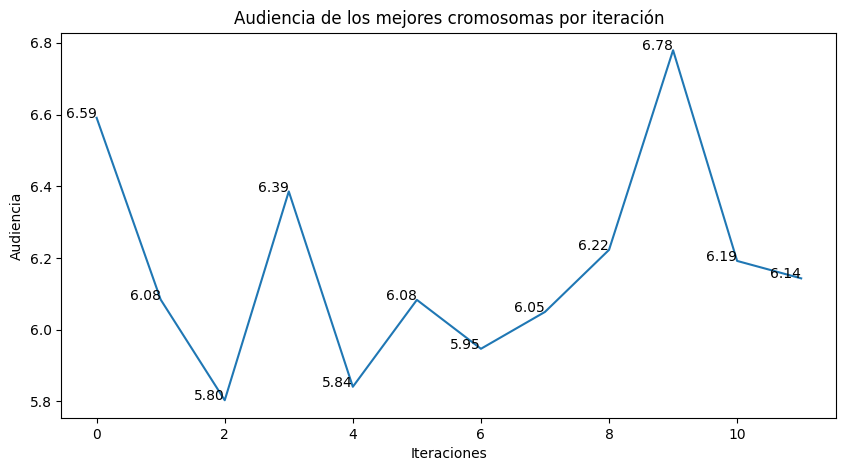

In [26]:
# Resumen de las Iteraciones
df_resultados_iteraciones = pd.DataFrame()

for key, value in resultados.items():
    df_temp = pd.DataFrame({'Cromosoma': [value[0]], 
                            'Audiencia Total': [value[1]], 
                            'Tamaño Poblacion': [value[2]], 
                            'Numero Generaciones': [value[3]], 
                            'Tasa Mutacion': [value[4]], 
                            'Numero Partidos': [value[5]]})
    df_resultados_iteraciones = pd.concat([df_resultados_iteraciones, df_temp], ignore_index=True)

display(df_resultados_iteraciones)

# Graficar los mejores audiencias por iteracion usando matplotlib
import matplotlib.pyplot as plt

# Estan en el diccionario resultados
audiencias_finales = [value[1] for key, value in resultados.items()]
plt.figure(figsize=(10,5))
plt.plot(audiencias_finales)
plt.xlabel('Iteraciones')
plt.ylabel('Audiencia')
plt.title('Audiencia de los mejores cromosomas por iteración')
# Agregar label a cada punto
for i, audiencia in enumerate(audiencias_finales):
    plt.text(i, audiencia, f'{audiencia:.2f}', ha='right')
plt.show()   

##### 11. Mejor Resultado (Mejor Cromosoma)

In [27]:
# Mostrar el mejor resultado global despues de las iteraciones (combinaciones de parámetros)
# resultados esquema = [cromosoma, audiencia_total,iteracion, tamano_poblacion, num_generaciones, tasa_mutacion, num_partidos]

# Obtener el key que corresponde con el valor maximo de audiencia_total
indice_max_audiencia = max(resultados, key=lambda key: resultados[key][1])

mejor_cromosoma_global = resultados[indice_max_audiencia][0]
mejor_audiencia_global = resultados[indice_max_audiencia][1]
mejor_iteracion_global = indice_max_audiencia
mejor_tamano_poblacion_global = resultados[indice_max_audiencia][2]
mejor_num_generaciones_global = resultados[indice_max_audiencia][3]
mejor_tasa_mutacion_global = resultados[indice_max_audiencia][4]
mejor_num_partidos_global = resultados[indice_max_audiencia][5]


print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Mejores resultados de las combinaciones de parámetros:")
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Mejor Iteración:", mejor_iteracion_global)
print("Mejor Tamaño de la población:", mejor_tamano_poblacion_global)
print("Mejor Número de generaciones:", mejor_num_generaciones_global)
print("Mejor Tasa de mutación:", mejor_tasa_mutacion_global)
print("Mejor Número de partidos:", mejor_num_partidos_global)
print("Mejor Audiencia Global:", mejor_audiencia_global)
print("Mejor Cromosoma:", mejor_cromosoma_global)

# Obtener representacion grafica (Dataframe) del mejor cromosoma global
calcular_aptitud(mejor_cromosoma_global, imprimir_resultado=True, iteracion='Global')

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mejores resultados de las combinaciones de parámetros:
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mejor Iteración: 9
Mejor Tamaño de la población: 20
Mejor Número de generaciones: 40
Mejor Tasa de mutación: 0.1
Mejor Número de partidos: 10
Mejor Audiencia Global: 6.7795000000000005
Mejor Cromosoma: [('B', 'C', 'V20'), ('C', 'C', 'L20'), ('C', 'C', 'D12'), ('B', 'B', 'S12'), ('C', 'B', 'S20'), ('B', 'A', 'S18'), ('B', 'B', 'S16'), ('B', 'B', 'D18'), ('B', 'B', 'D20'), ('A', 'A', 'D16')]
Audiencia total: 6.7795000000000005


,Partido,Equipo1,Equipo2,Horario,Base Audiencia,Ponderacion Horario,Base * Ponderacion,% Reduccion por Coincidencias,Reduccion Audiencia,Audiencia,Audiencia Final
0,1,B,C,V20,0.75,0.40,0.30,0.0,0.0,0.30,0.30
3,2,B,B,S12,0.90,0.55,0.50,0.0,0.0,0.50,0.80
6,3,B,B,S16,0.90,0.70,0.63,0.0,0.0,0.63,1.43
5,4,B,A,S18,1.30,0.80,1.04,0.0,0.0,1.04,2.47
4,5,C,B,S20,0.75,1.00,0.75,0.0,0.0,0.75,3.22
2,6,C,C,D12,0.47,0.45,0.21,0.0,0.0,0.21,3.43
9,7,A,A,D16,2.00,0.75,1.50,0.0,0.0,1.50,4.93
7,8,B,B,D18,0.90,0.85,0.77,0.0,0.0,0.77,5.70
8,9,B,B,D20,0.90,1.00,0.90,0.0,0.0,0.90,6.60
1,10,C,C,L20,0.47,0.40,0.19,0.0,0.0,0.19,6.79


6.7795000000000005

### Análisis de Modelo

- ¿Como represento el espacio de soluciones?

Para calcular el espacio de soluciones posibles, debemos considerar todas las combinaciones posibles de partidos y horarios. Sin embargo, dado que hay restricciones específicas (como la obligación de tener un partido el viernes y otro el lunes), el cálculo exacto del espacio de soluciones puede ser complejo.

Sin embargo, podemos hacer una estimación aproximada del espacio de soluciones considerando los siguientes puntos:

- Hay 20 equipos, lo que resulta en 10 partidos por jornada.
- Cada partido puede ser asignado a uno de los 10 horarios disponibles.
- Incluir las restricciones en el cálculo del espacio de soluciones hace que el cálculo sea más complejo, pero intentemos aproximarlo:

  - Restricción de un partido el viernes y uno el lunes: Esto reduce las opciones para esos dos partidos a 1 horario cada uno. Para los 8 partidos restantes, hay 8 horarios disponibles (excluyendo el viernes y el lunes).

  - Restricción de categorías de equipos: Dado que hay 3 equipos en la categoría A, 11 en la categoría B y 6 en la categoría C, el número de combinaciones posibles de partidos es limitado por la disponibilidad de equipos en cada categoría. Sin embargo, para simplificar, no consideraremos esta restricción en el cálculo del espacio de soluciones, ya que afecta principalmente a la audiencia y no a la asignación de horarios.
  

Dado lo anterior, el cálculo aproximado del espacio de soluciones sería:

Para los 2 partidos con horarios fijos (viernes y lunes), hay 1 opción cada uno.
Para los 8 partidos restantes, cada uno puede ser asignado a uno de los 8 horarios restantes.
Por lo tanto, el espacio de soluciones aproximado sería:

$1^{2} x 8^{8} = 16,777,216$

Este cálculo aún es una simplificación, ya que no considera todas las restricciones detalladas (como la reducción de audiencia por coincidencias de horarios). Sin embargo, proporciona una estimación más precisa que el cálculo anterior que no incluía restricciones.

En la práctica, el uso de algoritmos genéticos ayuda a explorar eficientemente este espacio de soluciones sin tener que enumerar todas las posibles combinaciones, lo que sería computacionalmente inviable.





- ¿Cual es la función objetivo?

La función objetivo en este problema es maximizar la audiencia total de los partidos de La Liga, sujeta a las restricciones dadas. Matemáticamente, la función objetivo se puede representar como:

### Maximizar
$$\sum_{i=1}^{N} \text{Audiencia}(\text{Partido}_i, \text{Horario}_i, \text{Coincidencias}_i)$$

donde:

- $N$ es el número total de partidos programados.
- $\text{Partido}_i$ es el i-ésimo partido, representado por un par de equipos.
- $\text{Horario}_i$ es el horario asignado al i-ésimo partido.
- $\text{Coincidencias}_i$ es el número de partidos que coinciden en el mismo horario que el i-ésimo partido.
- $\text{Audiencia}(\text{Partido}_i, \text{Horario}_i, \text{Coincidencias}_i)$ es la función que calcula la audiencia del i-ésimo partido, dada por:
  $$\text{Audiencia}(\text{Partido}_i, \text{Horario}_i, \text{Coincidencias}_i) = \text{AudienciaBase}(\text{Partido}_i) \times \text{CoeficienteHorario}(\text{Horario}_i) \times (1 - \text{ReduccionCoincidencias}(\text{Coincidencias}_i))$$

donde:

- $\text{AudienciaBase}(\text{Partido}_i)$ es la audiencia base del partido, que depende de las categorías de los equipos enfrentados.
- $\text{CoeficienteHorario}(\text{Horario}_i)$ es el coeficiente que ajusta la audiencia base según el horario del partido.
- $\text{ReduccionCoincidencias}(\text{Coincidencias}_i)$ es el porcentaje de reducción de la audiencia debido a la coincidencia de horarios con otros partidos.

La función objetivo busca encontrar la asignación de partidos a horarios que maximice esta suma total de audiencias, sujeta a las restricciones de horarios disponibles y la obligatoriedad de asignar un partido el viernes y otro el lunes.


- ¿Como implemento las restricciones?

Las restricciones se implementan de la siguiente manera:

- **Restricción de un partido el viernes y uno el lunes**: Esta restricción se maneja durante la generación de la población inicial y la mutación de los cromosomas. Cuando se crea un nuevo cromosoma (una posible solución), se verifica si ya hay un partido asignado a los horarios 'V20' (viernes a las 20 horas) y 'L20' (lunes a las 20 horas). Si no hay ninguno, se asigna el partido actual a ese horario. Esto se implementa en la función `generar_poblacion_inicial` y se repite de manera similar en la función `mutar` para asegurar que todas las soluciones generadas cumplan con esta restricción.

- **Restricción de categorías de equipos**: La categorización de los equipos y la asignación de audiencias base se manejan a través del diccionario `audiencias_base`. Este diccionario mapea los pares de equipos (categorías) a sus respectivas audiencias base. Durante el cálculo de la aptitud de un cromosoma, se utiliza este diccionario para obtener la audiencia base correspondiente a cada partido.

- **Restricción de reducción de audiencia por coincidencias de horarios**: Esta restricción se implementa en la función `calcular_aptitud`. Primero, se cuenta el número de partidos asignados a cada horario y luego se calcula la reducción de la audiencia basándose en el número de coincidencias, utilizando el diccionario `reduccion_por_coincidencias`. La audiencia final de cada partido se ajusta en función de esta reducción.

- **Restricción de horarios disponibles**: Los horarios disponibles se definen en la lista `horarios_disponibles`, y se utilizan durante la generación de la población inicial y la mutación de los cromosomas para asegurar que solo se asignen horarios válidos a los partidos.


### Análisis
- ¿Que complejidad tiene el problema?. Orden de complejidad y Contabilizar el espacio de soluciones

La complejidad del problema de optimización de horarios de partidos de La Liga depende de varios factores, incluyendo el número de equipos, el número de horarios disponibles y las restricciones específicas del problema. Dado que se trata de un problema de optimización combinatoria, su complejidad puede ser bastante alta.

### Orden de complejidad:

En términos del orden de complejidad, este problema es **NP-difícil** (no determinístico polinomial-difícil). Esto significa que no se conoce un algoritmo que pueda resolver el problema en tiempo polinomial en el tamaño de la entrada (número de equipos y horarios). La complejidad del problema crece exponencialmente con el número de equipos y horarios.

### Contabilización del espacio de soluciones:

Para contabilizar el espacio de soluciones, consideramos que hay 20 equipos y 10 horarios disponibles. Sin embargo, debido a las restricciones específicas (como la obligación de tener un partido el viernes y otro el lunes), el espacio de soluciones se reduce.

Una estimación aproximada del espacio de soluciones, considerando las restricciones, sería:

- 1 opción para el partido del viernes.
- 1 opción para el partido del lunes.
- 8 opciones para cada uno de los 8 partidos restantes (ya que dos horarios están ocupados por los partidos del viernes y del lunes).

Por lo tanto, el espacio de soluciones aproximado sería:

$$1 \times 1 \times 8^8 = 16,777,216$$

Esta es una estimación simplificada que no considera todas las restricciones detalladas, pero proporciona una idea de la magnitud del espacio de soluciones. En la práctica, el uso de técnicas como los algoritmos genéticos ayuda a explorar este espacio de soluciones de manera eficiente sin necesidad de enumerar todas las posibles combinaciones.


### Diseño

- ¿Que técnica utilizo? ¿Por qué?

Se utilizó la técnica del **algoritmo genético** para abordar el problema de optimización de horarios de partidos de La Liga.

### Razones para utilizar un algoritmo genético en este problema:

- **Exploración eficiente del espacio de soluciones**: Los algoritmos genéticos son capaces de explorar el espacio de soluciones de manera eficiente, evitando quedar atrapados en óptimos locales y buscando soluciones cercanas al óptimo global.

- **Flexibilidad para manejar restricciones**: Los algoritmos genéticos pueden adaptarse fácilmente para manejar diversas restricciones, como la asignación obligatoria de partidos en ciertos horarios y la reducción de audiencia por coincidencias.

- **Escalabilidad**: A medida que aumenta el número de equipos y horarios, el espacio de soluciones crece exponencialmente. Los algoritmos genéticos pueden escalar relativamente bien con el tamaño del problema, ofreciendo soluciones aproximadas en un tiempo razonable.

- **Paralelización**: Los algoritmos genéticos se prestan bien a la paralelización, lo que puede acelerar aún más la búsqueda de soluciones óptimas.

En resumen, se utiliza un algoritmo genético para este problema debido a su capacidad para explorar eficientemente un espacio de soluciones complejo y grande, manejar múltiples restricciones y ofrecer soluciones aproximadas en un tiempo razonable.
